### DelauVolu dataset generation. Compute DTFE, then remove duplicated triangles, apply density threshold and save to disk


In [1]:
from pyhull.delaunay import DelaunayTri
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(12345)

In [2]:
#-----------------------------------------------------
#
#-----------------------------------------------------
def tetra_volume(_a,_b,_c,_d):
    v1 = _b-_a
    v2 = _c-_a
    v3 = _d-_a
    
    return np.abs(( v1[:,0]*v2[:,1]*v3[:,2] + v1[:,1]*v2[:,2]*v3[:,0] + v1[:,2]*v2[:,0]*v3[:,1] - 
                   (v1[:,2]*v2[:,1]*v3[:,0] + v1[:,1]*v2[:,0]*v3[:,2] + v1[:,0]*v2[:,2]*v3[:,1]) ))/6.0

In [3]:
#-----------------------------------------------------
#
#-----------------------------------------------------
def adjacent_volumes(_xyz, _verts):

    #--- Compute volumes for all tetrahedron
    a = _xyz[_verts[:,0],:]
    b = _xyz[_verts[:,1],:]
    c = _xyz[_verts[:,2],:]
    d = _xyz[_verts[:,3],:] 
    tetra_volumes = tetra_volume(a,b,c,d)
    
    #--- Array to store adjacent volumes to each vertex
    adj_volumes = np.zeros(_xyz.shape[0])
    
    #--- Iterate over the volumes corresponding to the vertices array
    for i, tet_i in enumerate(_verts):
        #--- Iterate over the vertices in this tetrahedron and add its adjacent volume
        for ver_j in tet_i:
            adj_volumes[ver_j] = adj_volumes[ver_j] + tetra_volumes[i]
        
    return adj_volumes

In [4]:
#-----------------------------------------------------
#
#-----------------------------------------------------
def write_to_file(_filename, _xyz, _den, _tri):
    
    f = open(_filename, 'w')
    f.write("{}\n".format(len(_den)))
    for i in range(len(_den)):
        ##f.write('{:11.4f},{:11.4f},{:11.4f},{:11.4f}\n'.format(_xyz[i,0], _xyz[i,1], _xyz[i,2], _den[i]))
        f.write('{},{},{},{}\n'.format(_xyz[i,0], _xyz[i,1], _xyz[i,2], _den[i]))
        
    f.write("{}\n".format(len(_tri)))
    for item in _tri:
        f.write('{},{},{}\n'.format(item[0], item[1], item[2]))

    f.close()

In [5]:
#-----------------------------------------------------
#
#-----------------------------------------------------
def write_to_file_2(_filename, _xyz, _den, _tri):
    
    f = open(_filename+'_vert.csv', 'w')
    f.write("{}\n".format(len(_den)))
    for i in range(len(_den)):
        ##f.write('{:11.4f},{:11.4f},{:11.4f},{:11.4f}\n'.format(_xyz[i,0], _xyz[i,1], _xyz[i,2], _den[i]))
        f.write('{},{},{},{}\n'.format(_xyz[i,0], _xyz[i,1], _xyz[i,2], _den[i]))
    f.close()
        
    f = open(_filename+'_tri.csv', 'w')
    f.write("{}\n".format(len(_tri)))
    for item in _tri:
        f.write('{},{},{}\n'.format(item[0], item[1], item[2]))

    f.close()

In [6]:
def compute_mean_density(_n, _box):
    
    xyz = []
    for i in range(_n):
        xyz.append((np.random.uniform(0,_box), np.random.uniform(0,_box), np.random.uniform(0,_box)))
    xyz = np.asarray(xyz, dtype=np.float32)
    
    delau = DelaunayTri(xyz)

    tri = np.asarray(delau.vertices, dtype=np.int32)

    vol = adjacent_volumes(xyz, tri)
    
    #--- Remove zeroes from volume
    zer  = (vol ==0).nonzero()[0]
    nzer = (vol != 0).nonzero()[0]
    vol[zer] = np.min(vol[nzer])

    #--- Compute DTFE density
    den = (1.0 / vol) / 3.0
    
    return np.mean(den)

In [7]:
#-------------------------------------
#   Select tetrahedra that is not touching flagged data
#-------------------------------------
def select_valid_tretrahedra(_tetras, _flag):
    print('>>> original: ', len(_tetras))
    tetras = []
    #--- Loop over tetrahedra
    for item in _tetras:
        #--- Discard if at least one of the vertices is flagged
        if (_flag[item[0]] == False or _flag[item[1]] == False or _flag[item[2]] == False or _flag[item[3]] == False):
            continue
        tetras.append(item)
        
    print('>>> clean:', len(tetras))
    return tetras    

In [8]:
#-------------------------------------
#  Since the tessellation is a list of tetrahedra there are lots of
#    double triangles. This routine removes them and returns a list
#    of triangles.
#-------------------------------------
def remove_double_triangles_from_tessellation(_tetras):
    triangles = []
    for item in _tetras:
        triangles.append([item[0],item[1],item[2]])
        triangles.append([item[1],item[2],item[3]])
        triangles.append([item[0],item[1],item[3]])
        triangles.append([item[0],item[2],item[3]])

    triangles = remove_repeated_triangles(triangles)

    return triangles


In [9]:
#-------------------------------------
#  Constructs set of unique triplets. Note that this
#    is a destructive function as triplets are sorted first.
#
#  tris = [(0,1,2), (1,2,3), (2,3,4), (1,3,2), (3,2,1), (4,5,6), (2,1,0)]
#  clean = remove_repeated_triangles(tris)
#  print(clean)
#-------------------------------------
def remove_repeated_triangles(_tris):
    seti = set()
    for item in _tris:
        seti.add(tuple(np.sort(item)))

    return list(seti)

***
***

### Read particles from dataset and get subsample

(16777216,)


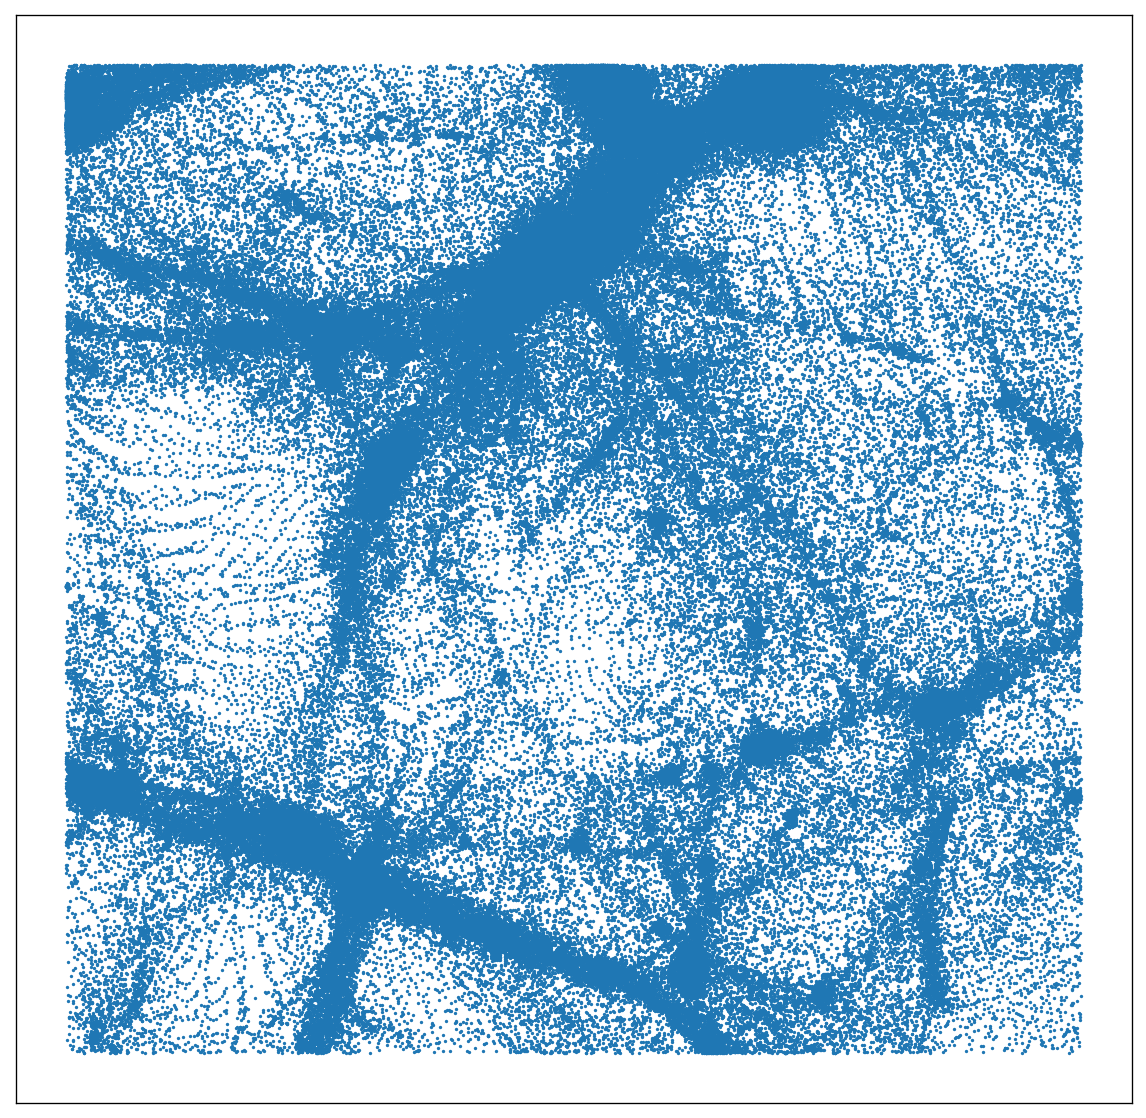

In [10]:
PATH = '/Users/miguel/Projects/Data/MIP-2/'

box = 3000.0

pos = np.load(PATH + 'run_150.npy')

x = pos[:,0]
y = pos[:,1]
z = pos[:,2]

print(x.shape)

sub = ((x < 16000) * (y < 16000) * (z < box)) .nonzero()[0]
x = pos[sub,0]
y = pos[sub,1]
z = pos[sub,2]

plt.figure(figsize=(12,12), dpi=120)
plt.xticks(())
plt.yticks(())

plt.scatter(x,y, s=1)
plt.show()

In [11]:
sub.shape

(587864,)

In [12]:
PATH = '/Users/miguel/Projects/Data/MIP-2/'

box = 8000.0

pos = np.load(PATH + 'run_150_sub.npy')

x = pos[:,0]
y = pos[:,1]
z = pos[:,2]

sub = ((x < box) * (y < box) * (z < box)) .nonzero()[0]
x = pos[sub,0]
y = pos[sub,1]
z = pos[sub,2]

In [13]:
xyz = []
for i in range(len(x)):
    xyz.append((x[i], y[i], z[i]))
xyz = np.asarray(xyz, dtype=np.float32)

### Compute Delaunay tessellation and adjacent volumes

In [14]:
delau  = DelaunayTri(xyz)
tetras = np.asarray(delau.vertices, dtype=np.int32)
vol    = adjacent_volumes(xyz, tetras)

### Remove zeroes (check why) and compute DTFE densities

In [15]:
#--- Remove zeroes from volume
zer  = (vol ==0).nonzero()[0]
nzer = (vol != 0).nonzero()[0]
vol[zer] = np.min(vol[nzer])

#--- Compute DTFE density
den = (1.0 / vol) / 3.0

### Subsample particles in overdensity range

In [16]:
#--- Only dense particles
mean_rho = compute_mean_density(len(x), box)

sub = ((den > mean_rho*0.5)*(den < mean_rho*1000)).nonzero()[0]

den2 = den[sub]
x2 = x[sub]
y2 = y[sub]
z2 = z[sub]

print(x.shape, x2.shape)

(208815,) (133014,)


### Plot valid particles

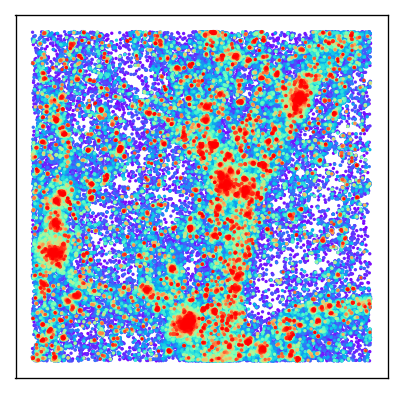

In [17]:
size2 = np.power(den2, 0.1)
size2 = size2-np.min(size2)
size2 = size2 / np.max(size2)

plt.figure(figsize=(4,4), dpi=120)
plt.xticks(())
plt.yticks(())

sorted = np.argsort(size2)
plt.scatter(x2[sorted],z2[sorted], s=1, c=size2[sorted]*255, cmap='rainbow')
plt.show()

### Select only tetrahedra in the range of densities specified. These tetrahedra do not touch any not-valid particle 

In [18]:
sub2 = (den > mean_rho*0.5)*(den < mean_rho*10000)

tetras_new = select_valid_tretrahedra(tetras, sub2)

>>> original:  1370635
>>> clean: 834874


### QHull gives the tessellation as a list of triangles which duplicates every triangle in adjacent tetrahedron. Remove duplicated triangles

In [19]:
print(len(tetras_new)*4)
tri_new = remove_double_triangles_from_tessellation(tetras_new)
print(len(tri_new))

size = np.power(den, 0.1)
size = size-np.min(size)
size = size / np.max(size)

write_to_file('test-8000-A.csv', xyz, size, tri_new)

write_to_file_2('test-8000-B', xyz, den/mean_rho, tri_new)



3339496
1731744


In [20]:
np.min(den[sub2.nonzero()]/mean_rho)

0.500080220497697